# Introduction
In this notebook the goal is to create a more robust and easy to understand, use and maintain code for preprocessing of data and model creation using the sklearn make_column_selector, make_column_transformer as well as model creation using make_pipeline. In addition, I have added model optimization with GridSearchCV and a prediction of one single datapoint. 

# Imports

In [397]:
import pandas as pd
import numpy as np

In [398]:
import time

In [399]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams.update(plt.rcParamsDefault)

In [400]:
#from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

#from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer

#from sklearn.linear_model import LinearRegression
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
#from sklearn.svm import SVR

#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import mean_absolute_percentage_error
#from sklearn.metrics import r2_score

In [401]:
from joblib import dump, load

# Read Data

In [402]:
car_data_ML = pd.read_csv('car_data_ML.csv')
car_data_ML.head(3)

,Unnamed: 0,brand,model,price_in_euro,power_ps,transmission_type,fuel_type,mileage_in_km,car_age
0,205,Alfa Romeo,Alfa Romeo 147,1250.0,105.0,Manual,Petrol,85000.0,16.9
1,149,Alfa Romeo,Alfa Romeo 147,2999.0,105.0,Manual,Petrol,171000.0,17.8
2,83,Alfa Romeo,Alfa Romeo 147,2700.0,120.0,Manual,Petrol,85600.0,20.6


# Data Selection
The ML algorithm selection is made based on a single car a close as it is possible based on the dataset. Each model is processed at once by the ML algorithm to avoid excessive memory usage. So for each car model an separate ML model is created. 

The dataset is grouped by models so that the model becomes an index in the dateframe and can be selected using this index when looping though the models later on. A good choice seems to be the most popular car VW Golf with manual transmission and pertrol engine. A slice from a model sub-dataset helps to better understand what happens with the data. The issue here is that the number of datapoints is not enough for a single generation of VW Golf, therefore the age is limited to 11 years with encopasses VW Golf VI to VIII.

**Creating the slice from model sub-dataset**

In [403]:
#car_data_ML = car_data_ML[(car_data_ML['model']=='Alfa Romeo Gt')]
car_data_ML = car_data_ML[(car_data_ML['model']=='Alfa Romeo Mito')]
#car_data_ML = car_data_ML[(car_data_ML['model']=='Alfa Romeo 147')]

In [404]:
#car_data_ML = car_data_ML[(car_data_ML['brand']=='Volkswagen')]

In [405]:
#car_data_ML = car_data_ML[(car_data_ML['model']=='Volkswagen Golf')]

In [406]:
# car_data_ML = car_data_ML[(car_data_ML['model']=='Volkswagen Golf') &\
#                           #(car_data_ML['power_ps']==150) &\
#                           (car_data_ML['transmission_type']=='Manual') &\
#                             (car_data_ML['fuel_type']=='Petrol') &\
#                           (car_data_ML['car_age']<11)]                       

In [407]:
car_data_ML

,Unnamed: 0,brand,model,price_in_euro,power_ps,transmission_type,fuel_type,mileage_in_km,car_age
509,425,Alfa Romeo,Alfa Romeo Mito,7500.0,170.0,Manual,Petrol,106000.0,11.1
510,424,Alfa Romeo,Alfa Romeo Mito,5490.0,105.0,Manual,Petrol,144390.0,11.3
511,422,Alfa Romeo,Alfa Romeo Mito,4490.0,84.0,Manual,Diesel,235000.0,10.7
512,406,Alfa Romeo,Alfa Romeo Mito,6970.0,95.0,Manual,Petrol,94000.0,12.2
513,421,Alfa Romeo,Alfa Romeo Mito,5490.0,95.0,Manual,Diesel,125700.0,10.9
...,...,...,...,...,...,...,...,...,...
600,645,Alfa Romeo,Alfa Romeo Mito,13980.0,140.0,Automatic,Petrol,52000.0,5.7
601,560,Alfa Romeo,Alfa Romeo Mito,9250.0,105.0,Manual,Petrol,77600.0,7.2
602,507,Alfa Romeo,Alfa Romeo Mito,6999.0,120.0,Manual,Diesel,141700.0,9.2
603,585,Alfa Romeo,Alfa Romeo Mito,13680.0,170.0,Automatic,Petrol,9020.0,5.8


**Dropping "Unnamed" and "brand columns**

In [408]:
car_data_ML.drop(columns=['Unnamed: 0','brand','model'],inplace=True)

# Separating dataset into train and test data

In [409]:
y = car_data_ML['price_in_euro']
X = car_data_ML.drop(columns=['price_in_euro'])

# Train-Test-Split

In [410]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=333)

In [411]:
X_train

,power_ps,transmission_type,fuel_type,mileage_in_km,car_age
577,95.0,Manual,Petrol,132500.0,14.0
530,95.0,Manual,Diesel,207429.0,10.3
539,135.0,Manual,Petrol,71288.0,13.1
524,95.0,Manual,Petrol,107000.0,12.5
550,155.0,Manual,Petrol,106885.0,14.1
...,...,...,...,...,...
555,95.0,Manual,Petrol,171000.0,14.3
560,95.0,Manual,Petrol,252300.0,14.0
544,105.0,Manual,Petrol,161000.0,11.0
586,95.0,Manual,Petrol,139223.0,14.3


# Creating ML Model

In [412]:
car_data_ML

,price_in_euro,power_ps,transmission_type,fuel_type,mileage_in_km,car_age
509,7500.0,170.0,Manual,Petrol,106000.0,11.1
510,5490.0,105.0,Manual,Petrol,144390.0,11.3
511,4490.0,84.0,Manual,Diesel,235000.0,10.7
512,6970.0,95.0,Manual,Petrol,94000.0,12.2
513,5490.0,95.0,Manual,Diesel,125700.0,10.9
...,...,...,...,...,...,...
600,13980.0,140.0,Automatic,Petrol,52000.0,5.7
601,9250.0,105.0,Manual,Petrol,77600.0,7.2
602,6999.0,120.0,Manual,Diesel,141700.0,9.2
603,13680.0,170.0,Automatic,Petrol,9020.0,5.8


The remaining dateset consists of 240 datapoints and should be enough to get an idea how the different algorithms perform

**Creating Pre-Processor**

In [413]:
preprocessor = make_column_transformer(
    (MinMaxScaler(), make_column_selector(dtype_exclude=object)),
    (OneHotEncoder(), make_column_selector(dtype_include=object))
)

**Defining ML Algorithm**

In [414]:
reg_alg = KNeighborsRegressor()

**Creating the model**

In [415]:
model = make_pipeline(preprocessor, reg_alg)

**Fitting Model**

In [416]:
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4368df92e0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4368df9be0>)])),
                ('kneighborsregressor', KNeighborsRegressor())])

In [417]:
model.predict(X_test)

array([ 3205.8,  6638. ,  4853.8,  8728. ,  6861.6,  4064. ,  4946. ,
        5252.8, 14569.8, 10178. , 13859.8,  8758. ,  5094. ,  6861.6,
        4838. ,  7221.8,  7289.8,  5558. ,  7024. ,  4815.8])

**Printing Score (R2)** 

In [418]:
print('Training set accuracy:', np.round(model.score(X_train, y_train), 2))
print('Test set accuracy:' , np.round(model.score(X_test, y_test), 2))

Training set accuracy: 0.82
Test set accuracy: 0.61


# Optimizing ML Model

**Defining parameters for the gridsearch**

In [419]:
parameters = {'n_neighbors':[int(n) for n in np.linspace(5,50,10)],
              'algorithm':('ball_tree','kd_tree','brute'),
              'weights':('uniform', 'distance'),
              'metric':('euclidean','manhattan')      
}

**Creating Gridsearch Object**

In [420]:
GS = GridSearchCV(estimator=reg_alg,param_grid=parameters,verbose=3,return_train_score=True,refit=True)

**Creating pipeline using the peprocessor created earlier**

In [421]:
model_opt = make_pipeline(preprocessor, GS)

**Fitting the model using parameter grid**

In [422]:
model_opt.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END algorithm=ball_tree, metric=euclidean, n_neighbors=5, weights=uniform;, score=(train=0.832, test=0.483) total time=   0.0s
[CV 2/5] END algorithm=ball_tree, metric=euclidean, n_neighbors=5, weights=uniform;, score=(train=0.840, test=0.515) total time=   0.0s
[CV 3/5] END algorithm=ball_tree, metric=euclidean, n_neighbors=5, weights=uniform;, score=(train=0.840, test=0.456) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, metric=euclidean, n_neighbors=5, weights=uniform;, score=(train=0.687, test=0.798) total time=   0.0s
[CV 5/5] END algorithm=ball_tree, metric=euclidean, n_neighbors=5, weights=uniform;, score=(train=0.781, test=0.737) total time=   0.0s
[CV 1/5] END algorithm=ball_tree, metric=euclidean, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.533) total time=   0.0s
[CV 2/5] END algorithm=ball_tree, metric=euclidean, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.571) to

[CV 3/5] END algorithm=ball_tree, metric=euclidean, n_neighbors=40, weights=uniform;, score=(train=0.297, test=0.086) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, metric=euclidean, n_neighbors=40, weights=uniform;, score=(train=0.205, test=-0.027) total time=   0.0s
[CV 5/5] END algorithm=ball_tree, metric=euclidean, n_neighbors=40, weights=uniform;, score=(train=0.255, test=0.215) total time=   0.0s
[CV 1/5] END algorithm=ball_tree, metric=euclidean, n_neighbors=40, weights=distance;, score=(train=1.000, test=0.299) total time=   0.0s
[CV 2/5] END algorithm=ball_tree, metric=euclidean, n_neighbors=40, weights=distance;, score=(train=1.000, test=0.780) total time=   0.0s
[CV 3/5] END algorithm=ball_tree, metric=euclidean, n_neighbors=40, weights=distance;, score=(train=1.000, test=0.213) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, metric=euclidean, n_neighbors=40, weights=distance;, score=(train=1.000, test=0.549) total time=   0.0s
[CV 5/5] END algorithm=ball_tree, me

[CV 3/5] END algorithm=ball_tree, metric=manhattan, n_neighbors=25, weights=uniform;, score=(train=0.558, test=0.186) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, metric=manhattan, n_neighbors=25, weights=uniform;, score=(train=0.428, test=0.270) total time=   0.0s
[CV 5/5] END algorithm=ball_tree, metric=manhattan, n_neighbors=25, weights=uniform;, score=(train=0.499, test=0.503) total time=   0.0s
[CV 1/5] END algorithm=ball_tree, metric=manhattan, n_neighbors=25, weights=distance;, score=(train=1.000, test=0.410) total time=   0.0s
[CV 2/5] END algorithm=ball_tree, metric=manhattan, n_neighbors=25, weights=distance;, score=(train=1.000, test=0.833) total time=   0.0s
[CV 3/5] END algorithm=ball_tree, metric=manhattan, n_neighbors=25, weights=distance;, score=(train=1.000, test=0.260) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, metric=manhattan, n_neighbors=25, weights=distance;, score=(train=1.000, test=0.780) total time=   0.0s
[CV 5/5] END algorithm=ball_tree, met

[CV 2/5] END algorithm=kd_tree, metric=euclidean, n_neighbors=15, weights=distance;, score=(train=1.000, test=0.800) total time=   0.0s
[CV 3/5] END algorithm=kd_tree, metric=euclidean, n_neighbors=15, weights=distance;, score=(train=1.000, test=0.382) total time=   0.0s
[CV 4/5] END algorithm=kd_tree, metric=euclidean, n_neighbors=15, weights=distance;, score=(train=1.000, test=0.823) total time=   0.0s
[CV 5/5] END algorithm=kd_tree, metric=euclidean, n_neighbors=15, weights=distance;, score=(train=1.000, test=0.752) total time=   0.0s
[CV 1/5] END algorithm=kd_tree, metric=euclidean, n_neighbors=20, weights=uniform;, score=(train=0.623, test=0.368) total time=   0.0s
[CV 2/5] END algorithm=kd_tree, metric=euclidean, n_neighbors=20, weights=uniform;, score=(train=0.585, test=0.632) total time=   0.0s
[CV 3/5] END algorithm=kd_tree, metric=euclidean, n_neighbors=20, weights=uniform;, score=(train=0.617, test=0.292) total time=   0.0s
[CV 4/5] END algorithm=kd_tree, metric=euclidean, n

[CV 2/5] END algorithm=kd_tree, metric=manhattan, n_neighbors=5, weights=uniform;, score=(train=0.812, test=0.514) total time=   0.0s
[CV 3/5] END algorithm=kd_tree, metric=manhattan, n_neighbors=5, weights=uniform;, score=(train=0.832, test=0.257) total time=   0.0s
[CV 4/5] END algorithm=kd_tree, metric=manhattan, n_neighbors=5, weights=uniform;, score=(train=0.696, test=0.781) total time=   0.0s
[CV 5/5] END algorithm=kd_tree, metric=manhattan, n_neighbors=5, weights=uniform;, score=(train=0.782, test=0.747) total time=   0.0s
[CV 1/5] END algorithm=kd_tree, metric=manhattan, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.540) total time=   0.0s
[CV 2/5] END algorithm=kd_tree, metric=manhattan, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.561) total time=   0.0s
[CV 3/5] END algorithm=kd_tree, metric=manhattan, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.297) total time=   0.0s
[CV 4/5] END algorithm=kd_tree, metric=manhattan, n_neighbo

[CV 1/5] END algorithm=kd_tree, metric=manhattan, n_neighbors=45, weights=distance;, score=(train=1.000, test=0.297) total time=   0.0s
[CV 2/5] END algorithm=kd_tree, metric=manhattan, n_neighbors=45, weights=distance;, score=(train=1.000, test=0.812) total time=   0.0s
[CV 3/5] END algorithm=kd_tree, metric=manhattan, n_neighbors=45, weights=distance;, score=(train=1.000, test=0.258) total time=   0.0s
[CV 4/5] END algorithm=kd_tree, metric=manhattan, n_neighbors=45, weights=distance;, score=(train=1.000, test=0.608) total time=   0.0s
[CV 5/5] END algorithm=kd_tree, metric=manhattan, n_neighbors=45, weights=distance;, score=(train=1.000, test=0.536) total time=   0.0s
[CV 1/5] END algorithm=kd_tree, metric=manhattan, n_neighbors=50, weights=uniform;, score=(train=0.200, test=0.094) total time=   0.0s
[CV 2/5] END algorithm=kd_tree, metric=manhattan, n_neighbors=50, weights=uniform;, score=(train=0.186, test=0.136) total time=   0.0s
[CV 3/5] END algorithm=kd_tree, metric=manhattan, 

[CV 5/5] END algorithm=brute, metric=euclidean, n_neighbors=35, weights=uniform;, score=(train=0.331, test=0.302) total time=   0.0s
[CV 1/5] END algorithm=brute, metric=euclidean, n_neighbors=35, weights=distance;, score=(train=1.000, test=0.312) total time=   0.0s
[CV 2/5] END algorithm=brute, metric=euclidean, n_neighbors=35, weights=distance;, score=(train=1.000, test=0.803) total time=   0.0s
[CV 3/5] END algorithm=brute, metric=euclidean, n_neighbors=35, weights=distance;, score=(train=1.000, test=0.231) total time=   0.0s
[CV 4/5] END algorithm=brute, metric=euclidean, n_neighbors=35, weights=distance;, score=(train=1.000, test=0.608) total time=   0.0s
[CV 5/5] END algorithm=brute, metric=euclidean, n_neighbors=35, weights=distance;, score=(train=1.000, test=0.556) total time=   0.0s
[CV 1/5] END algorithm=brute, metric=euclidean, n_neighbors=40, weights=uniform;, score=(train=0.294, test=0.060) total time=   0.0s
[CV 2/5] END algorithm=brute, metric=euclidean, n_neighbors=40, 

[CV 1/5] END algorithm=brute, metric=manhattan, n_neighbors=25, weights=distance;, score=(train=1.000, test=0.410) total time=   0.0s
[CV 2/5] END algorithm=brute, metric=manhattan, n_neighbors=25, weights=distance;, score=(train=1.000, test=0.833) total time=   0.0s
[CV 3/5] END algorithm=brute, metric=manhattan, n_neighbors=25, weights=distance;, score=(train=1.000, test=0.260) total time=   0.0s
[CV 4/5] END algorithm=brute, metric=manhattan, n_neighbors=25, weights=distance;, score=(train=1.000, test=0.780) total time=   0.0s
[CV 5/5] END algorithm=brute, metric=manhattan, n_neighbors=25, weights=distance;, score=(train=1.000, test=0.687) total time=   0.0s
[CV 1/5] END algorithm=brute, metric=manhattan, n_neighbors=30, weights=uniform;, score=(train=0.463, test=0.245) total time=   0.0s
[CV 2/5] END algorithm=brute, metric=manhattan, n_neighbors=30, weights=uniform;, score=(train=0.438, test=0.431) total time=   0.0s
[CV 3/5] END algorithm=brute, metric=manhattan, n_neighbors=30, 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4368df92e0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4368df9be0>)])),
                ('gridsearchcv',
                 GridSearchCV(estimator=KNeighborsRegressor(),
                              param_grid={'algorithm': ('ball_tree', 'kd_tree',
                                                        'brute'),
                                          'metric': ('euclidean', 'manhattan'),
                                          'n_neighbors': [5, 10, 15, 20, 25, 30,
                                                          35, 40, 45, 50],
                                          'weights': ('uniform', 'distance')},
                              return_train_score=True, verbose=3))])

In [423]:
#GS.best_estimator_ 

**Best score from all tested parameters**

In [424]:
GS.best_score_

0.6497572565174721

**Parameters that achieved the best score**

In [425]:
GS.best_params_

{'algorithm': 'ball_tree',
 'metric': 'manhattan',
 'n_neighbors': 15,
 'weights': 'distance'}

**Training score for comparison with the default parameters**

In [426]:
print('Training set accuracy:', np.round(model_opt.score(X_train, y_train), 2))
print('Test set accuracy:' , np.round(model_opt.score(X_test, y_test), 2))

Training set accuracy: 1.0
Test set accuracy: 0.65


Please note that the fold used to define the best parameters is actually not the same as fold created during the train-test-split. 

## Saving Model

In [427]:
dump(model_opt, 'model.joblib') 

['model.joblib']

## Loading Model

In [428]:
model_load = load('model.joblib')

## Make predictions for test data

In [429]:
predictions = model_load.predict(X_test)

## Creating a single datapoint for Prediction

**Getting columns for the datapoint**

In [430]:
X_keys = np.array(X.keys().to_list())
X_keys

array(['power_ps', 'transmission_type', 'fuel_type', 'mileage_in_km',
       'car_age'], dtype='<U17')

**Defining values for the datapoint**

In [431]:
X_values = [[140,'Manual','Petrol',100000,10]]

**Creating Dataframe for the datapoint**

In [432]:
X = pd.DataFrame(data=X_values,columns=X_keys)

In [433]:
X

,power_ps,transmission_type,fuel_type,mileage_in_km,car_age
0,140,Manual,Petrol,100000,10


## Predicting Price for the single datapoint

In [434]:
prediction_single = np.round(model_load.predict(X))
prediction_single

array([7795.])

# Vusializing data

## Creating a plot function

In [435]:
def plot_results(X_train,y_train,X_test,y_test,predictions):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,5),sharey=True)
    fig.tight_layout()
    ax1.scatter(x=X_train['mileage_in_km'],y=y_train,color='blue',alpha=0.3,label='y_train')
    ax1.set_title('Training Data')
    ax1.set_ylabel('Price in Euro')
    ax1.legend()
    ax2.scatter(x=X_test['mileage_in_km'],y=y_test,color='blue',alpha=0.3,label='y_test')
    ax2.scatter(x=X_test['mileage_in_km'],y=predictions,color='red',alpha=0.3,label='predictions')
    ax2.scatter(x=X['mileage_in_km'],y=prediction_single,color='yellow',alpha=1,label='single_datapoint')
    ax2.set_title('Testing Data vs Predictions')
    ax2.legend()
    fig.text(0.5,-0.02, "Mileage in km", ha="center", va="center")
    plt.show() 

## Plotting data

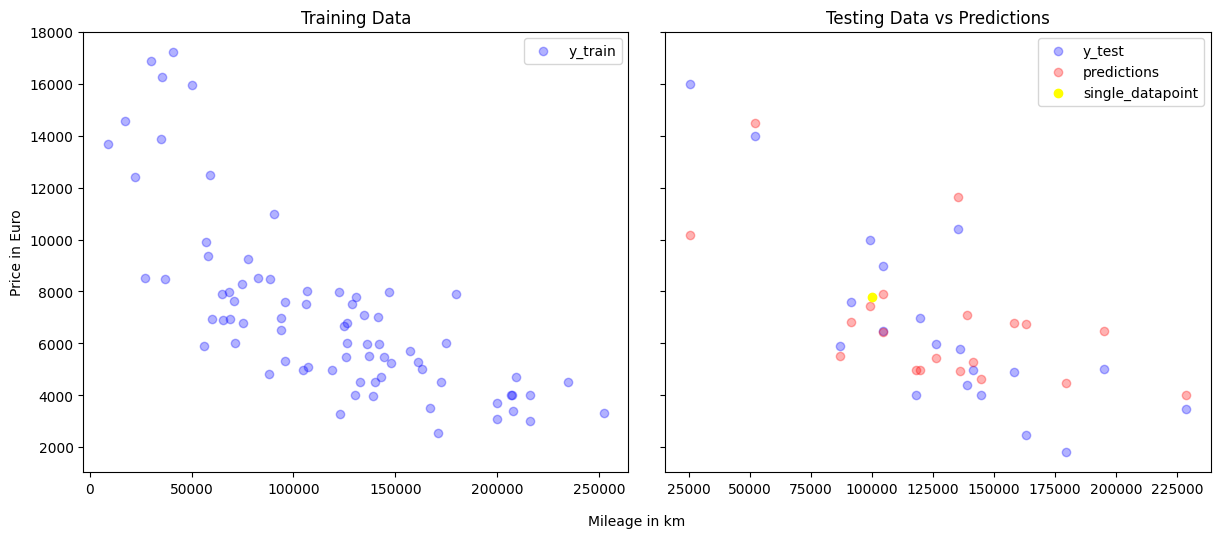

In [436]:
plot_results(X_train,y_train,X_test,y_test,predictions)